In [1]:
#pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#pip freeze > env.txt

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import torch
print(torch.cuda.is_available())

True


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
import zipfile
zip_file=zipfile.ZipFile("./1092kDa unit.zip")
zip_file.extractall("1092kDa")

In [7]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [8]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [9]:
import torchvision.models as models
resnet50 = models.resnet50()

In [10]:
import tensorflow.keras

In [11]:
# Check GPU and fix the random seed
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


In [12]:
import resnet
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [13]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=11, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d): #class type matching -> true or false
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        #print(x.shape)
        #x.shape =[1, 16, 32,32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        #print(x.shape)
        #x.shape =[1, 128, 32,32]
        x = self.layer2(x)
        #print(x.shape)
        #x.shape =[1, 256, 32,32]
        x = self.layer3(x)
        #print(x.shape)
        #x.shape =[1, 512, 16,16]
        x = self.layer4(x)
        #print(x.shape)
        #x.shape =[1, 1024, 8,8]
        
        x = self.avgpool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 11, True).to(device)
#1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [14]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**K_FOLD(적절한 튜닝 파라미터 찾기 위해 진행)**

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


Fold : 1, train : 4400, test : 1100

Epoch: 0
Loss: 2.43, Acc: 6.25% (2/32)
Loss: 2.65, Acc: 8.51% (275/3232)
Loss: 2.59, Acc: 8.86% (390/4400)

Epoch: 1
Loss: 2.40, Acc: 15.62% (5/32)
Loss: 2.43, Acc: 8.79% (284/3232)
Loss: 2.43, Acc: 8.75% (385/4400)

Epoch: 2
Loss: 2.39, Acc: 9.38% (3/32)
Loss: 2.25, Acc: 15.90% (514/3232)
Loss: 2.16, Acc: 18.25% (803/4400)

Epoch: 3
Loss: 1.85, Acc: 34.38% (11/32)
Loss: 1.44, Acc: 44.43% (1436/3232)
Loss: 1.30, Acc: 49.70% (2187/4400)

Epoch: 4
Loss: 0.54, Acc: 84.38% (27/32)
Loss: 0.65, Acc: 77.26% (2497/3232)
Loss: 0.59, Acc: 79.45% (3496/4400)

Epoch: 5
Loss: 0.30, Acc: 90.62% (29/32)
Loss: 0.34, Acc: 88.64% (2865/3232)
Loss: 0.31, Acc: 89.48% (3937/4400)

Epoch: 6
Loss: 0.12, Acc: 96.88% (31/32)
Loss: 0.24, Acc: 91.58% (2960/3232)
Loss: 0.24, Acc: 91.34% (4019/4400)

Epoch: 7
Loss: 0.19, Acc: 90.62% (29/32)
Loss: 0.22, Acc: 92.17% (2979/3232)
Loss: 0.21, Acc: 92.59% (4074/4400)

Epoch: 8
Loss: 0.09, Acc: 96.88% (31/32)
Loss: 0.19, Acc: 93.25% 

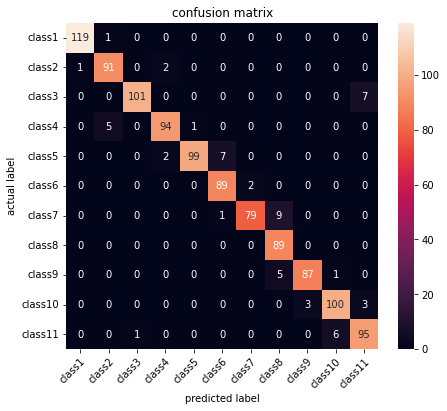

Accuracy for fold 0: 94 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 0 FOLDS
--------------------------------
Fold 0: 94.81818181818183 %
Average: 94.81818181818183 %

Fold : 2, train : 4400, test : 1100

Epoch: 0
Loss: 0.15, Acc: 93.75% (30/32)
Loss: 0.20, Acc: 93.16% (3011/3232)
Loss: 0.19, Acc: 93.30% (4105/4400)

Epoch: 1
Loss: 0.13, Acc: 96.88% (31/32)
Loss: 0.17, Acc: 93.97% (3037/3232)
Loss: 0.17, Acc: 93.86% (4130/4400)

Epoch: 2
Loss: 0.14, Acc: 93.75% (30/32)
Loss: 0.16, Acc: 93.94% (3036/3232)
Loss: 0.16, Acc: 94.23% (4146/4400)

Epoch: 3
Loss: 0.28, Acc: 90.62% (29/32)
Loss: 0.16, Acc: 94.43% (3052/3232)
Loss: 0.17, Acc: 94.05% (4138/4400)

Epoch: 4
Loss: 0.16, Acc: 96.88% (31/32)
Loss: 0.15, Acc: 94.15% (3043/3232)
Loss: 0.16, Acc: 93.86% (4130/4400)

Epoch: 5
Loss: 0.06, Acc: 100.00% (32/32)
Loss: 0.17, Acc: 93.75% (3030/3232)
Loss: 0.18, Acc: 93.41% (4110/4400)

Epoch: 6
Loss: 0.13, Acc: 96.88% (31/32)
Loss: 0.16, Acc: 94.49% (3054/3232)
Loss: 0

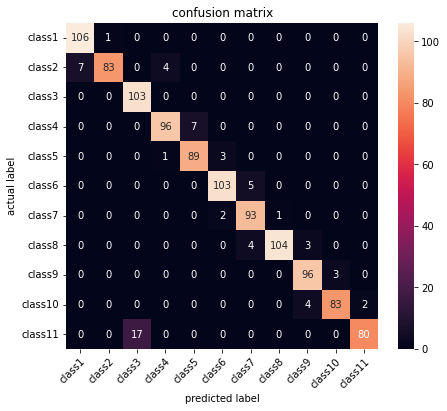

Accuracy for fold 1: 94 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 1 FOLDS
--------------------------------
Fold 0: 94.81818181818183 %
Average: 47.409090909090914 %
Fold 1: 94.18181818181817 %
Average: 94.5 %

Fold : 3, train : 4400, test : 1100

Epoch: 0
Loss: 0.12, Acc: 96.88% (31/32)
Loss: 0.14, Acc: 94.96% (3069/3232)
Loss: 0.14, Acc: 94.73% (4168/4400)

Epoch: 1
Loss: 0.22, Acc: 87.50% (28/32)
Loss: 0.15, Acc: 94.83% (3065/3232)
Loss: 0.15, Acc: 94.95% (4178/4400)

Epoch: 2
Loss: 0.17, Acc: 93.75% (30/32)
Loss: 0.13, Acc: 95.14% (3075/3232)
Loss: 0.14, Acc: 95.07% (4183/4400)

Epoch: 3
Loss: 0.17, Acc: 90.62% (29/32)
Loss: 0.14, Acc: 95.30% (3080/3232)
Loss: 0.15, Acc: 94.73% (4168/4400)

Epoch: 4
Loss: 0.22, Acc: 87.50% (28/32)
Loss: 0.14, Acc: 95.02% (3071/3232)
Loss: 0.16, Acc: 94.32% (4150/4400)

Epoch: 5
Loss: 0.13, Acc: 96.88% (31/32)
Loss: 0.16, Acc: 94.37% (3050/3232)
Loss: 0.15, Acc: 94.52% (4159/4400)

Epoch: 6
Loss: 0.08, Acc: 96.88% (31/32)

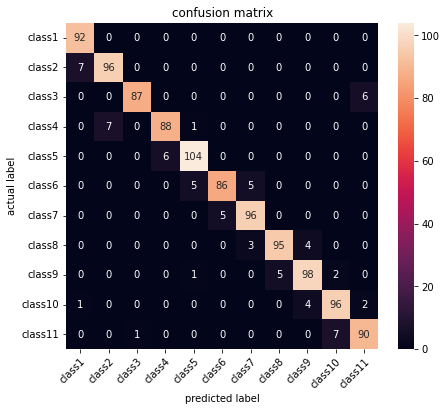

Accuracy for fold 2: 93 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 2 FOLDS
--------------------------------
Fold 0: 94.81818181818183 %
Average: 31.60606060606061 %
Fold 1: 94.18181818181817 %
Average: 63.0 %
Fold 2: 93.45454545454545 %
Average: 94.15151515151514 %

Fold : 4, train : 4400, test : 1100

Epoch: 0
Loss: 0.06, Acc: 100.00% (32/32)
Loss: 0.15, Acc: 94.59% (3057/3232)
Loss: 0.15, Acc: 94.55% (4160/4400)

Epoch: 1
Loss: 0.18, Acc: 93.75% (30/32)
Loss: 0.15, Acc: 94.18% (3044/3232)
Loss: 0.15, Acc: 94.14% (4142/4400)

Epoch: 2
Loss: 0.22, Acc: 93.75% (30/32)
Loss: 0.15, Acc: 94.99% (3070/3232)
Loss: 0.15, Acc: 94.77% (4170/4400)

Epoch: 3
Loss: 0.10, Acc: 96.88% (31/32)
Loss: 0.14, Acc: 95.17% (3076/3232)
Loss: 0.15, Acc: 95.18% (4188/4400)

Epoch: 4
Loss: 0.19, Acc: 90.62% (29/32)
Loss: 0.14, Acc: 94.86% (3066/3232)
Loss: 0.14, Acc: 94.55% (4160/4400)

Epoch: 5
Loss: 0.11, Acc: 93.75% (30/32)
Loss: 0.12, Acc: 95.48% (3086/3232)
Loss: 0.13, Acc: 95.

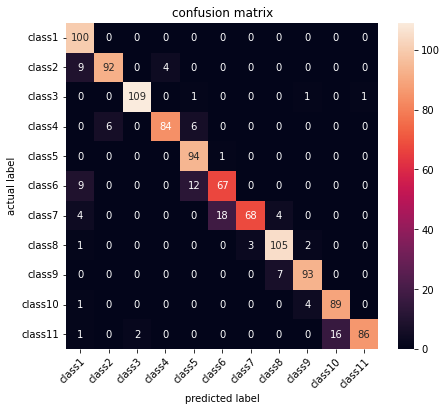

Accuracy for fold 3: 89 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 94.81818181818183 %
Average: 23.704545454545457 %
Fold 1: 94.18181818181817 %
Average: 47.25 %
Fold 2: 93.45454545454545 %
Average: 70.61363636363636 %
Fold 3: 89.72727272727272 %
Average: 93.04545454545453 %

Fold : 5, train : 4400, test : 1100

Epoch: 0
Loss: 0.15, Acc: 93.75% (30/32)
Loss: 0.16, Acc: 94.40% (3051/3232)
Loss: 0.16, Acc: 94.68% (4166/4400)

Epoch: 1
Loss: 0.07, Acc: 100.00% (32/32)
Loss: 0.14, Acc: 94.77% (3063/3232)
Loss: 0.14, Acc: 94.95% (4178/4400)

Epoch: 2
Loss: 0.09, Acc: 96.88% (31/32)
Loss: 0.12, Acc: 95.79% (3096/3232)
Loss: 0.12, Acc: 95.73% (4212/4400)

Epoch: 3
Loss: 0.04, Acc: 100.00% (32/32)
Loss: 0.12, Acc: 95.92% (3100/3232)
Loss: 0.12, Acc: 95.95% (4222/4400)

Epoch: 4
Loss: 0.09, Acc: 100.00% (32/32)
Loss: 0.11, Acc: 96.23% (3110/3232)
Loss: 0.11, Acc: 95.91% (4220/4400)

Epoch: 5
Loss: 0.07, Acc: 100.00% (3

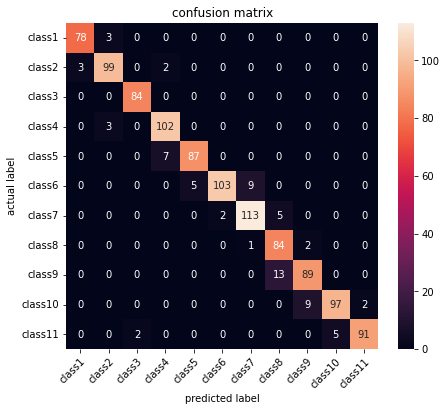

Accuracy for fold 4: 93 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------
Fold 0: 94.81818181818183 %
Average: 18.963636363636365 %
Fold 1: 94.18181818181817 %
Average: 37.8 %
Fold 2: 93.45454545454545 %
Average: 56.490909090909085 %
Fold 3: 89.72727272727272 %
Average: 74.43636363636362 %
Fold 4: 93.36363636363636 %
Average: 93.1090909090909 %


In [16]:
import pandas as pd
from sklearn.model_selection import KFold
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score,f1_score, roc_curve
from sklearn.metrics import classification_report 


data_dir="./1092kDa"
results = {}
#transforms methods (size, shape transform : to tensor)
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])    
train_data = datasets.ImageFolder(data_dir,transform=train_transforms)
   
kf= KFold(n_splits=5,shuffle=True, random_state=42)

for j,(train_idx,test_idx) in enumerate(kf.split(train_data)):
    train = torch.utils.data.Subset(train_data, train_idx)
    test = torch.utils.data.Subset(train_data, test_idx)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32, num_workers=2, shuffle=True)
    testloader = torch.utils.data.DataLoader(test, batch_size=32, num_workers=2, shuffle=True)
    print("")
    print('Fold : {}, train : {}, test : {}'.format(j+1, len(trainloader.dataset), len(testloader.dataset)))

    for epoch in range(15):
      print('\nEpoch: %d' % epoch)
      resnet50.train()
      train_loss = 0
      correct = 0
      total = 0

      for batch_idx, (inputs, targets) in enumerate(trainloader):
        #print('batch idx : ',batch_idx)
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = resnet50(inputs).to(device) #output = 각 클래스 별 확률, 16개 return
        loss = criterion(outputs, targets) #output = 예측값, target = 원래 정답
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1) # 32개 이미지 각각에서 가장 큰 확률 값을 가져옴 predicted = 예측한 클래스 
        total += targets.size(0) # Accuracy 를 구해야하므로 전체 dataset 이 몇개 인지를 iterative 하게 update (target size = 배치 안의 이미지 개수)
        correct += predicted.eq(targets).sum().item() 
        del(inputs,targets)
        if batch_idx % 100 == 0:
          print('Loss: %.2f, Acc: %.2f%% (%d/%d)' 
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      print('Loss: %.2f, Acc: %.2f%% (%d/%d)' 
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))       

    with torch.no_grad():
        resnet50.eval()
        test_loss = 0
        correct = 0
        total = 0
        y_predict_list=[]
        y_true_list=[] 
        for i, (inputs, targets) in enumerate(testloader,0):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = resnet50(inputs).to(device)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            y_predict_list += [int(o.argmax()) for o in outputs]
            y_true_list += [int(r) for r in targets]
            result = classification_report( y_true_list,y_predict_list, output_dict=True)
        print(result)
    print('Loss: %.2f, Acc: %.2f%% (%d/%d)'% (test_loss / (i + 1), 100. * correct / total, correct, total))
    
        
    #confusioin matrix for this fold
    nb_classes=11
    confusion_matrix = torch.zeros(nb_classes,nb_classes)
    with torch.no_grad():    
          for i, (inputs, classes) in enumerate(testloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = resnet50(inputs)
            _, preds = torch.max(outputs, 1)
            for t,p in zip(classes.view(-1),preds.view(-1)):
                confusion_matrix[t.long(),p.long()] += 1
    classes=['class1','class2','class3','class4','class5','class6','class7','class8','class9','class10','class11']
    conf_mat = confusion_matrix
    fig,ax=plt.subplots(figsize=(7,6))
    sns.heatmap(conf_mat,annot=True,fmt='.0f',xticklabels=classes,yticklabels=classes)
    plt.setp(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
    plt.title('confusion matrix')
    plt.ylabel('actual label')
    plt.xlabel('predicted label')
    plt.show()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (j, 100.0 * correct / total))
    print('--------------------------------')
    results[j] = 100.0 * (correct / total)
    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {j} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
        print(f'Average: {sum/len(results.items())} %')

In [18]:
print('k-fold average:')
(94.82+94.18+93.45+89.73+93.36)/5

k-fold average:


93.108